In [22]:
import os
import time
 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
 
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
 
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

#https://github.com/iamirmasoud/energy_consumption_prediction/blob/master/Energy%20consumption%20prediction%20using%20LSTM-GRU%20in%20PyTorch.ipynb

#http://www.sefidian.com/2020/01/30/gated-recurrent-unit-gru-with-pytorch/

In [23]:
# from google.colab import drive
# drive.mount('/content/drive')


In [24]:
# # Define data root directory
# data_dir = "/content/drive/MyDrive/Colab Notebooks/10DeepLearningRNN_TimeSeries_StockProject/energy/"
# # Visualise how our data looks
# dataset = pd.read_csv(data_dir + 'AEP_hourly.csv').head()

In [25]:
# # Define data root directory
data_dir = "./data/"
# # Visualise how our data looks
dataset = pd.read_csv(data_dir + 'AEP_hourly.csv').head()

# Exploratory Data Analysis (EDA)

In [26]:
# Define data root directory
print(os.listdir(data_dir))

['est_hourly.paruqet', 'PJMW_hourly.csv', 'pjm_hourly_est.csv', 'PJM_Load_hourly.csv', 'DAYTON_hourly.csv', 'NI_hourly.csv', 'PJME_hourly.csv', 'FE_hourly.csv', 'DOM_hourly.csv', 'EKPC_hourly.csv', 'DEOK_hourly.csv', 'DUQ_hourly.csv', 'AEP_hourly.csv', 'COMED_hourly.csv']


In [27]:
pd.read_csv(os.path.join(data_dir, "DEOK_hourly.csv")).head()


,Datetime,DEOK_MW
0,2012-12-31 01:00:00,2945.0
1,2012-12-31 02:00:00,2868.0
2,2012-12-31 03:00:00,2812.0
3,2012-12-31 04:00:00,2812.0
4,2012-12-31 05:00:00,2860.0


# Feature Engineering 

## Create training instances by moving sliding window

In [28]:
def move_sliding_window(data, window_size, inputs_cols_indices, label_col_index):
    """
    data: numpy array including data
    window_size: size of window
    inputs_cols_indices: col indices to include
    """

    # (# instances created by movement, seq_len (timestamps), # features (input_len))
    inputs = np.zeros((len(data) - window_size, window_size, len(inputs_cols_indices)))
    labels = np.zeros(len(data) - window_size)

    for i in range(window_size, len(data)):
        inputs[i - window_size] = data[i - window_size : i, inputs_cols_indices]
        labels[i - window_size] = data[i, label_col_index]
    inputs = inputs.reshape(-1, window_size, len(inputs_cols_indices))
    labels = labels.reshape(-1, 1)
    print(inputs.shape, labels.shape)

    return inputs, labels

## Integrate files to build the training set

In [29]:
label_col_index = 0  # consumption as label to predict
inputs_cols_indices = range(
    5
)  # use (consumption, hour, dayofweek, month, dayofyear) columns as features

# Define window_size period and split inputs/labels
window_size = 90

# The scaler objects will be stored in this dictionary so that our output test data from the model can be re-scaled during evaluation
label_scalers = {}

train_x = []
test_x = {}
test_y = {}

# Skipping the files we're not using
processing_files = [
    file for file in os.listdir(data_dir) if os.path.splitext(file)[1] == ".csv"
]

num_files_for_dataset = 1#5

for file in tqdm(processing_files[:num_files_for_dataset]):
    print(f"Processing {file} ...")
    # Store csv file in a Pandas DataFrame
    df = pd.read_csv(os.path.join(data_dir, file), parse_dates=["Datetime"])

    # Processing the time data into suitable input formats
    df["hour"] = df.apply(lambda x: x["Datetime"].hour, axis=1)
    df["dayofweek"] = df.apply(lambda x: x["Datetime"].dayofweek, axis=1)
    df["month"] = df.apply(lambda x: x["Datetime"].month, axis=1)
    df["dayofyear"] = df.apply(lambda x: x["Datetime"].dayofyear, axis=1)
    df = df.sort_values("Datetime").drop("Datetime", axis=1)

    # Scaling the input data
    sc = MinMaxScaler()
    label_sc = MinMaxScaler()
    data = sc.fit_transform(df.values)

    # Obtaining the scaler for the labels(usage data) so that output can be
    # re-scaled to actual value during evaluation
    label_sc.fit(df.iloc[:, label_col_index].values.reshape(-1, 1))
    label_scalers[file] = label_sc

    # Move the window
    inputs, labels = move_sliding_window(
        data,
        window_size,
        inputs_cols_indices=inputs_cols_indices,
        label_col_index=label_col_index,
    )

    # CONCAT created instances from all .csv files.
    # Split data into train/test portions and combining all data from different files into a single array
    test_portion = int(0.1 * len(inputs))
    if len(train_x) == 0:  # first iteration
        train_x = inputs[:-test_portion]
        train_y = labels[:-test_portion]
    else:
        train_x = np.concatenate((train_x, inputs[:-test_portion]))
        train_y = np.concatenate((train_y, labels[:-test_portion]))
    test_x[file] = inputs[-test_portion:]
    test_y[file] = labels[-test_portion:]

  0%|          | 0/1 [00:00<?, ?it/s]

Processing PJMW_hourly.csv ...


100%|██████████| 1/1 [00:03<00:00,  3.03s/it]

(143116, 90, 5) (143116, 1)


## What have we made?

In [30]:
train_x.shape, test_x["PJMW_hourly.csv"].shape


((128805, 90, 5), (14311, 90, 5))

## Pytorch data loaders/ generators

In [31]:
batch_size = 100 #1024 

train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))

# Drop the last incomplete batch
train_loader = DataLoader(
    train_data, shuffle=True, batch_size=batch_size, drop_last=True
)

In [32]:
# release some memory
del train_x, train_y

In [43]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")

device

device(type='cpu')

# Model & Training

## Build Model

In [34]:
class GRUNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
        super(GRUNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.gru = nn.GRU(
            input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob
        )
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x, h):
        out, h = self.gru(x, h)
        # print(out[:, -1].shape, h.shape)
        # select hidden state of last timestamp (t=90) (1024, 256)
        out = self.fc(self.relu(out[:, -1]))  # out[:, -1, :]
        # print(out.shape) # (1024, 1)
        return out, h

    def init_hidden(self, batch_size):
        # Initialze h_0 with zeros
        weight = next(self.parameters()).data
        hidden = (
            weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        )
        return hidden


class LSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
        super(LSTMNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.lstm = nn.LSTM(
            input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob
        )
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x, h):
        out, h = self.lstm(x, h)
        out = self.fc(self.relu(out[:, -1]))
        return out, h

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        # Initialze h_0, c_0 with zeros
        hidden = (
            weight.new(self.n_layers, batch_size, self.hidden_dim)
            .zero_()
            .to(device),  # h_0
            weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
        )
        return hidden

## Build Training 

In [35]:
def train(
    train_loader,
    learn_rate,
    hidden_dim=256,
    n_layers=2,
    n_epochs=5,
    model_type="GRU",
    print_every=100,
):

    input_dim = next(iter(train_loader))[0].shape[2]  # 5

    # Batch generator (train_data, train_label)
    # print(next(iter(train_loader))[0].shape, next(iter(train_loader))[1].shape) # torch.Size([1024, 90, 5]) torch.Size([1024, 1])

    output_dim = 1

    # Instantiating the models
    if model_type == "GRU":
        model = GRUNet(input_dim, hidden_dim, output_dim, n_layers)
    else:
        model = LSTMNet(input_dim, hidden_dim, output_dim, n_layers)
    model.to(device)

    # Defining loss function and optimizer
    criterion = nn.MSELoss()  # Mean Squared Error
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)

    model.train()
    print("Starting Training of {} model".format(model_type))
    epoch_times = []

    # Start training loop
    for epoch in range(1, n_epochs + 1):
        start_time = time.process_time()
        h = model.init_hidden(batch_size)
        avg_loss = 0.0
        counter = 0
        for x, label in train_loader:
            counter += 1
            if model_type == "GRU":
                h = h.data
            # Unpcak both h_0 and c_0
            elif model_type == "LSTM":
                h = tuple([e.data for e in h])

            # Set the gradients to zero before starting to do backpropragation because
            # PyTorch accumulates the gradients on subsequent backward passes
            model.zero_grad()

            out, h = model(x.to(device).float(), h)
            loss = criterion(out, label.to(device).float())

            # Perform backpropragation
            loss.backward()
            optimizer.step()

            avg_loss += loss.item()
            if counter % print_every == 0:
                print(
                    f"Epoch {epoch} - Step: {counter}/{len(train_loader)} - Average Loss for Epoch: {avg_loss/counter}"
                )
        current_time = time.process_time()

        print(
            f"Epoch {epoch}/{n_epochs} Done, Total Loss: {avg_loss/len(train_loader)}"
        )

        print(f"Time Elapsed for Epoch: {current_time-start_time} seconds")

        epoch_times.append(current_time - start_time)

    print(f"Total Training Time: {sum(epoch_times)} seconds")
    return model

## Training and Save the GRU model

In [36]:
# seq_len = 90  # (timestamps)
n_hidden = 256
n_layers = 2
n_epochs = 5
print_every = 100
lr = 0.001
gru_model = train(
    train_loader,
    learn_rate=lr,
    hidden_dim=n_hidden,
    n_layers=n_layers,
    n_epochs=n_epochs,
    model_type="GRU",
    print_every=print_every,
)

Starting Training of GRU model
Epoch 1 - Step: 100/1288 - Average Loss for Epoch: 0.014129905798472463
Epoch 1 - Step: 200/1288 - Average Loss for Epoch: 0.007946089713368566
Epoch 1 - Step: 300/1288 - Average Loss for Epoch: 0.005715731805345664
Epoch 1 - Step: 400/1288 - Average Loss for Epoch: 0.0045450325236015485
Epoch 1 - Step: 500/1288 - Average Loss for Epoch: 0.003784290374373086
Epoch 1 - Step: 600/1288 - Average Loss for Epoch: 0.0032648393546696754
Epoch 1 - Step: 700/1288 - Average Loss for Epoch: 0.002873402735027152
Epoch 1 - Step: 800/1288 - Average Loss for Epoch: 0.002566879490914289
Epoch 1 - Step: 900/1288 - Average Loss for Epoch: 0.0023235670595022385
Epoch 1 - Step: 1000/1288 - Average Loss for Epoch: 0.0021252174622641176
Epoch 1 - Step: 1100/1288 - Average Loss for Epoch: 0.00195896401611125
Epoch 1 - Step: 1200/1288 - Average Loss for Epoch: 0.0018191358348728197
Epoch 1/5 Done, Total Loss: 0.001714616326534049
Time Elapsed for Epoch: 381.314246 seconds
Epoch 

In [37]:
torch.save(gru_model.state_dict(), "./model/gru_model.pt")


## Training and Save the LSTM Model

In [38]:
lstm_model = train(
    train_loader,
    learn_rate=lr,
    hidden_dim=n_hidden,
    n_layers=n_layers,
    n_epochs=n_epochs,
    model_type="LSTM",
    print_every=print_every,
)

Starting Training of LSTM model
Epoch 1 - Step: 100/1288 - Average Loss for Epoch: 0.024087350801564753
Epoch 1 - Step: 200/1288 - Average Loss for Epoch: 0.01362880009051878
Epoch 1 - Step: 300/1288 - Average Loss for Epoch: 0.00988697072956711
Epoch 1 - Step: 400/1288 - Average Loss for Epoch: 0.007939792838587891
Epoch 1 - Step: 500/1288 - Average Loss for Epoch: 0.006681772200274281
Epoch 1 - Step: 600/1288 - Average Loss for Epoch: 0.005769008751085494
Epoch 1 - Step: 700/1288 - Average Loss for Epoch: 0.005067349488298143
Epoch 1 - Step: 800/1288 - Average Loss for Epoch: 0.004522288475454843
Epoch 1 - Step: 900/1288 - Average Loss for Epoch: 0.0040886898320685655
Epoch 1 - Step: 1000/1288 - Average Loss for Epoch: 0.003732690515986178
Epoch 1 - Step: 1100/1288 - Average Loss for Epoch: 0.003438798442207785
Epoch 1 - Step: 1200/1288 - Average Loss for Epoch: 0.0031909211211071428
Epoch 1/5 Done, Total Loss: 0.003002769280219977
Time Elapsed for Epoch: 500.710012 seconds
Epoch 2 -

In [39]:
torch.save(lstm_model.state_dict(), "./model/lstm_model.pt")


# Evaluating Models

## Loading the GRU model

In [40]:
# move device to cpu for evaluation to avoid GPU memory run
device = "gpu"

In [41]:
## input_dim = next(iter(train_loader))[0].shape[2]  # 5
## train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
## train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)

hidden_dim = 256
input_dim = 5
output_dim = 1
n_layers = 2
gru_model = GRUNet(input_dim, hidden_dim, output_dim, n_layers)
gru_model.load_state_dict(torch.load("./model/gru_model.pt"))

<All keys matched successfully>

In [44]:
# Move the model to the appropriate device
gru_model.to(device)

GRUNet(
  (gru): GRU(5, 256, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (relu): ReLU()
)

## Load the LSTM model

In [45]:
hidden_dim = 256
input_dim = 5
output_dim = 1
n_layers = 2
lstm_model = LSTMNet(input_dim, hidden_dim, output_dim, n_layers)
lstm_model.load_state_dict(torch.load("./model/lstm_model.pt"))

<All keys matched successfully>

In [46]:
# Move the model to the appropriate device
lstm_model.to(device)

LSTMNet(
  (lstm): LSTM(5, 256, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (relu): ReLU()
)

# Model Evaluation

In [47]:
def sMAPE(outputs, targets):
    sMAPE = (
        100
        / len(targets)
        * np.sum(np.abs(outputs - targets) / (np.abs(outputs + targets)) / 2)
    )
    return sMAPE

In [48]:
def evaluate(model, test_x, test_y, label_scalers):
    model.eval()
    outputs = []
    targets = []
    start_time = time.process_time()
    # get data of test data for each state
    for file in test_x.keys():
        inputs = torch.from_numpy(np.array(test_x[file]))
        labels = torch.from_numpy(np.array(test_y[file]))

        h = model.init_hidden(inputs.shape[0])

        # predict outputs
        with torch.no_grad():
            out, h = model(inputs.to(device).float(), h)

        outputs.append(
            label_scalers[file]
            .inverse_transform(out.cpu().detach().numpy())
            .reshape(-1)
        )

        targets.append(
            label_scalers[file].inverse_transform(labels.numpy()).reshape(-1)
        )

    # Merge all files
    concatenated_outputs = np.concatenate(outputs)
    concatenated_targets = np.concatenate(targets)

    print(f"Evaluation Time: {time.process_time()-start_time}")
    print(f"sMAPE: {round(sMAPE(concatenated_outputs, concatenated_targets), 3)}%")

    # list of of targets/outputs for each state
    return outputs, targets, sMAPE

# Evaluate performance of GRU & LSTM

In [49]:
gru_outputs, targets, gru_sMAPE = evaluate(gru_model, test_x, test_y, label_scalers)


Evaluation Time: 18.919497999999294
sMAPE: 0.298%


In [50]:
lstm_outputs, targets, lstm_sMAPE = evaluate(lstm_model, test_x, test_y, label_scalers)


Evaluation Time: 24.264178000000356
sMAPE: 0.272%


In [51]:
len(
    gru_outputs
)  # list of predicted output file for each state (each element has a 1d array for that state)

1

# Some visualizations

In [52]:
states_list = list(test_x.keys())


In [53]:
states_list


['PJMW_hourly.csv']

IndexError: list index out of range

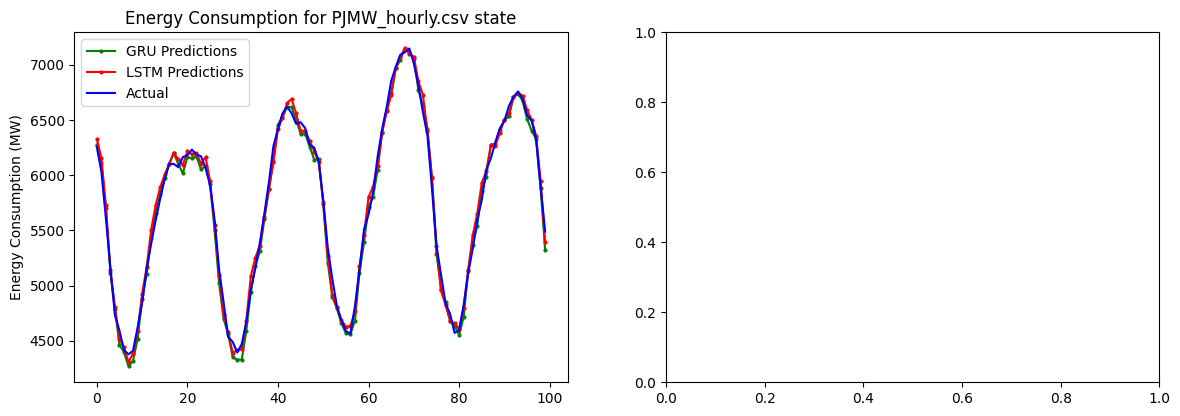

In [54]:
plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
plt.plot(gru_outputs[0][-100:], "-o", color="g", label="GRU Predictions", markersize=2)
plt.plot(
    lstm_outputs[0][-100:], "-o", color="r", label="LSTM Predictions", markersize=2
)
plt.plot(targets[0][-100:], color="b", label="Actual")
plt.ylabel("Energy Consumption (MW)")
plt.title(f"Energy Consumption for {states_list[0]} state")
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(gru_outputs[1][-50:], "-o", color="g", label="GRU Predictions", markersize=2)
plt.plot(lstm_outputs[1][-50:], "-o", color="r", label="LSTM Predictions", markersize=2)
plt.plot(targets[1][-50:], color="b", label="Actual")
plt.ylabel("Energy Consumption (MW)")
plt.title(f"Energy Consumption for {states_list[1]} state")
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(gru_outputs[2][:50], "-o", color="g", label="GRU Predictions", markersize=2)
plt.plot(lstm_outputs[2][:50], "-o", color="r", label="LSTM Predictions", markersize=2)
plt.plot(targets[2][:50], color="b", label="Actual")
plt.ylabel("Energy Consumption (MW)")
plt.title(f"Energy Consumption for {states_list[2]} state")
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(gru_outputs[3][:100], "-o", color="g", label="GRU Predictions", markersize=2)
plt.plot(lstm_outputs[3][:100], "-o", color="r", label="LSTM Predictions", markersize=2)
plt.plot(targets[3][:100], color="b", label="Actual")
plt.title(f"Energy Consumption for {states_list[3]} state")
plt.ylabel("Energy Consumption (MW)")
plt.legend()
plt.show()